# Dataset Columns

1. `id`: Unique identifier for each observation.
2. `Product ID`: Identifier for the product associated with the observation.
3. `Type`: The type of the product.
4. `Air temperature [K]`: The air temperature in Kelvin during the observation.
5. `Process temperature [K]`: The process temperature in Kelvin during the observation.
6. `Rotational speed [rpm]`: The rotational speed in revolutions per minute during the observation.
7. `Torque [Nm]`: The torque in Newton meter during the observation.
8. `Tool wear [min]`: The tool wear in minutes during the observation.
9. `Machine failure`: Binary variable indicating whether a machine failure occurred (1) or not (0).
10. `TWF`: Binary variable indicating whether a tool wear failure occurred (1) or not (0).
11. `HDF`: Binary variable indicating whether a heat dissipation failure occurred (1) or not (0).
12. `PWF`: Binary variable indicating whether a power failure occurred (1) or not (0).
13. `OSF`: Binary variable indicating whether an overstrain failure occurred (1) or not (0).
14. `RNF`: Binary variable indicating whether a random failure occurred (1) or not (0).

# Evaluation

Submissions are evaluated on the area under the ROC curve between the predicted probability and the observed target.

# Submission File

For each `id` in the test set, you must predict the probability of a `Machine failure`. The file should contain a header and have the following format:

```id,Machine failure```
* 136429,0.5
* 136430,0.1
* 136431,0.9
* etc.

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, classification_report, confusion_matrix

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_palette(sns.color_palette("pastel"))
plt.rcParams["figure.figsize"] = [14, 6]

In [3]:
df = pd.read_csv("../data/Binary Classification of Machine Failures/train.csv")

In [4]:
df.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [5]:
enc = LabelEncoder()

def preprocess(df):
    df.columns = df.columns.str.replace('[^\w\s]', '', regex=True)
    
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            df[label] = enc.fit_transform(content)

    return df

In [6]:
df = preprocess(df)

In [7]:
df.dtypes

id                         int64
Product ID                 int32
Type                       int32
Air temperature K        float64
Process temperature K    float64
Rotational speed rpm       int64
Torque Nm                float64
Tool wear min              int64
Machine failure            int64
TWF                        int64
HDF                        int64
PWF                        int64
OSF                        int64
RNF                        int64
dtype: object

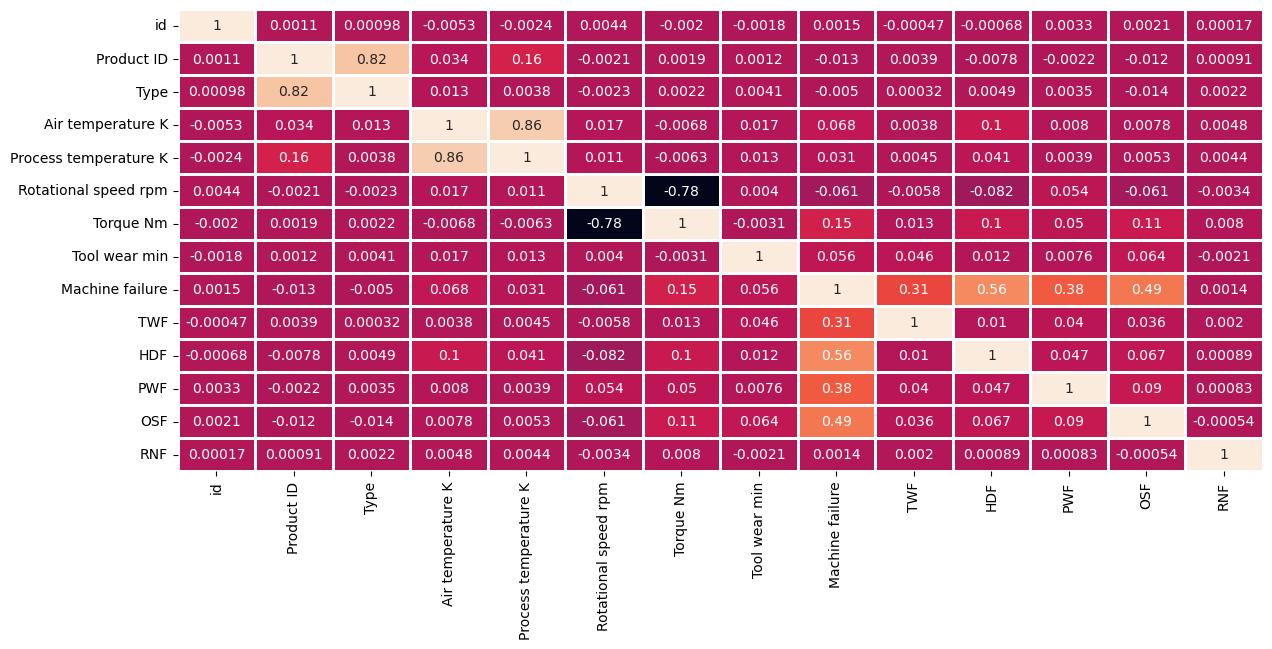

In [8]:
sns.heatmap(df.corr(), annot=True, cbar=False, linewidths=0.9);

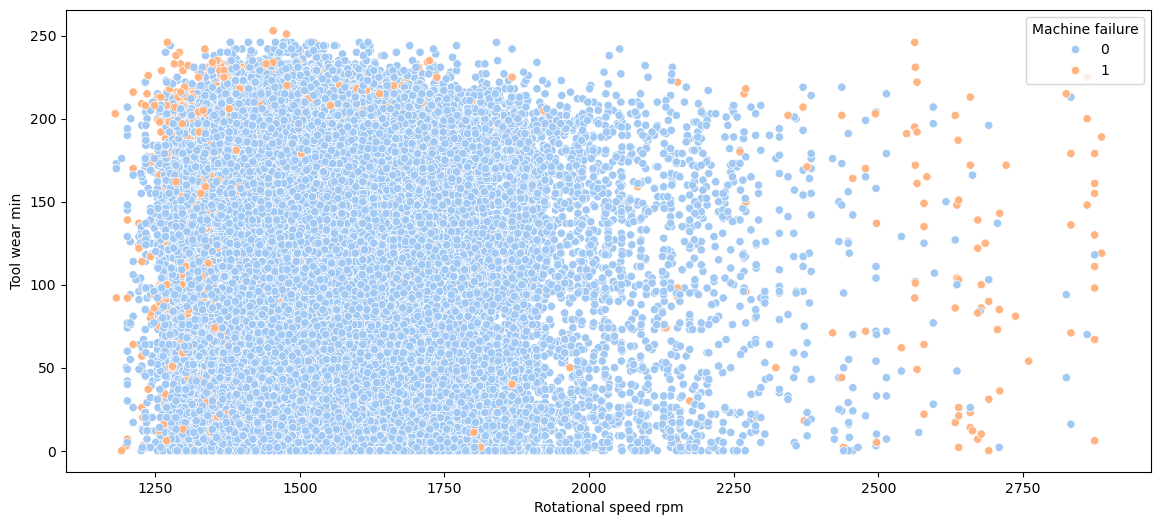

In [9]:
sns.scatterplot(data=df, x="Rotational speed rpm", y="Tool wear min", hue="Machine failure");

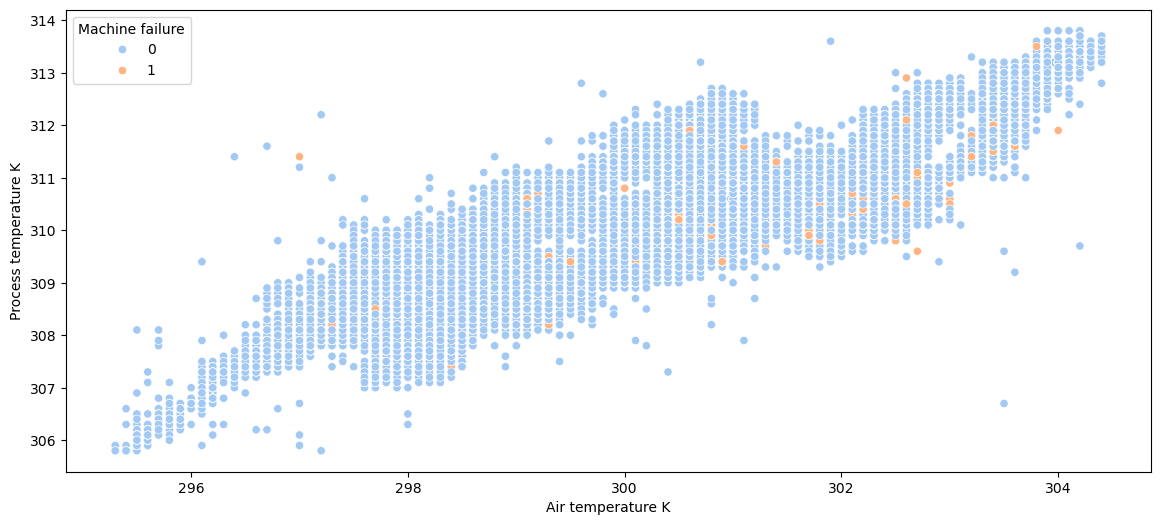

In [10]:
sns.scatterplot(data=df, x="Air temperature K", y="Process temperature K", hue="Machine failure");

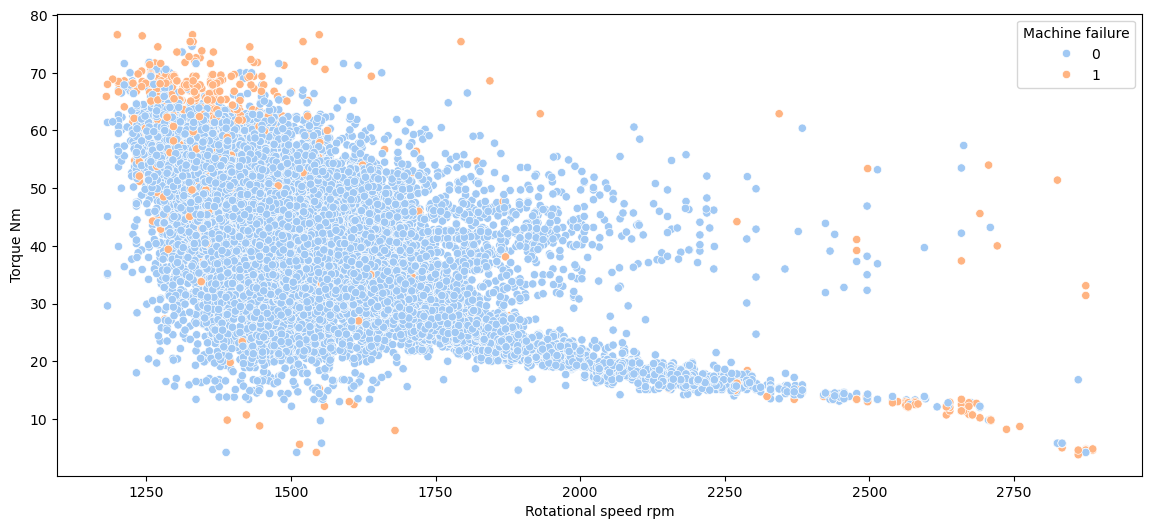

In [11]:
sns.scatterplot(data=df, x="Rotational speed rpm", y="Torque Nm", hue="Machine failure");

In [12]:
X = df.drop("Machine failure", axis=1)
y = df["Machine failure"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [14]:
X_train.shape, y_train.shape

((95500, 13), (95500,))

In [15]:
%%time
xgb = XGBClassifier().fit(X_train, y_train)

CPU times: total: 1.16 s
Wall time: 307 ms


In [16]:
xgb.score(X_test, y_test)

0.9958464658310733

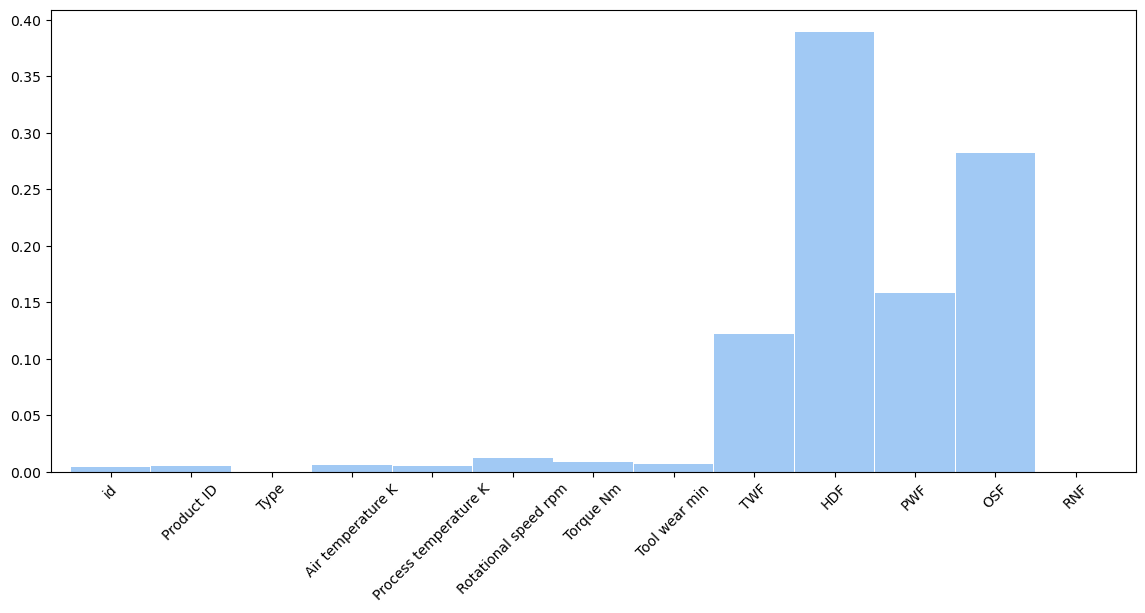

In [17]:
feature_df = pd.DataFrame(xgb.feature_importances_, X_test.columns)
feature_df.plot(kind="bar", width=0.99, legend=False)
plt.xticks(rotation=45);

In [18]:
y_preds = xgb.predict(X_test)

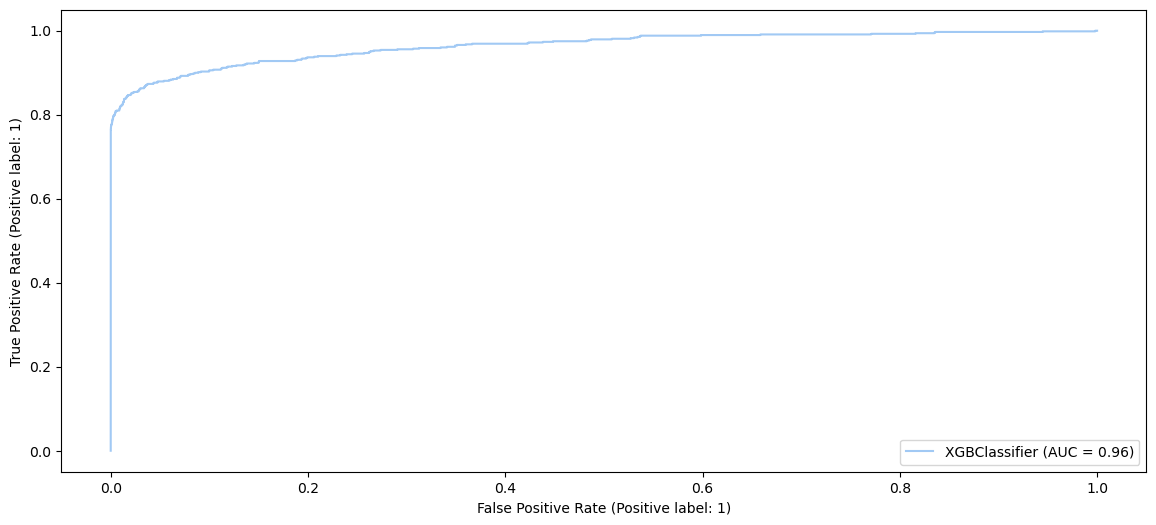

In [19]:
RocCurveDisplay.from_estimator(xgb, X_test, y_test);

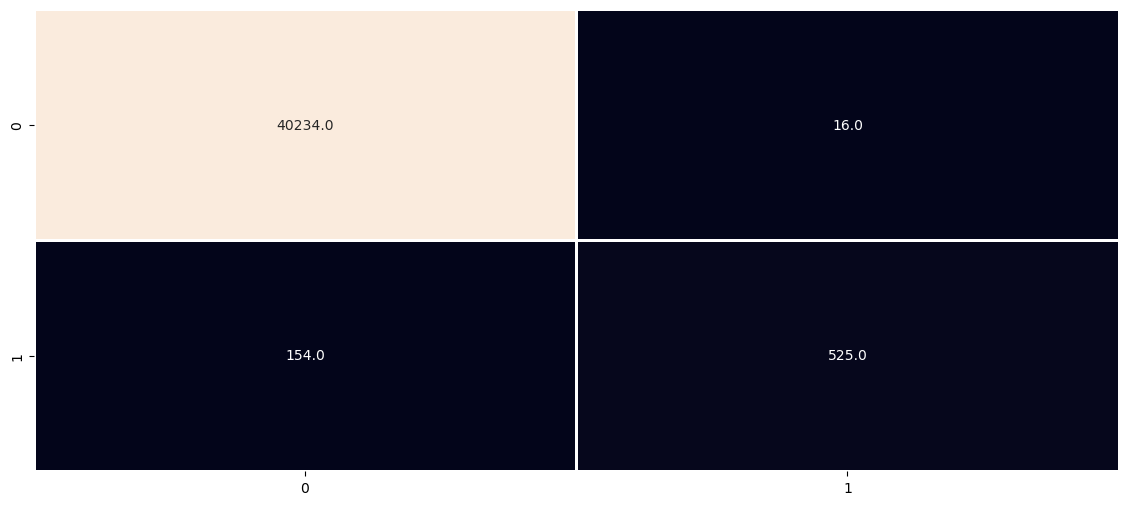

In [20]:
sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, cbar=False, linewidths=0.9, fmt=".1f");

In [21]:
test_df = pd.read_csv("../data/Binary Classification of Machine Failures/test.csv")

In [22]:
test_df.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


In [23]:
test_df.isna().sum()

id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [24]:
test_df = preprocess(test_df)

In [28]:
y_preds_proba = xgb.predict_proba(test_df)

In [29]:
len(test_df["id"])

90954

In [30]:
len(y_preds_proba[:, 1])

90954

In [48]:
result_df = test_df[["id"]].copy()
result_df["Machine failure"] = y_preds_proba[:, 1]

In [49]:
result_df.head()

,id,Machine failure
0,136429,0.000043
1,136430,0.000781
2,136431,0.000167
3,136432,0.000023
4,136433,0.000136
